### Ce notebook est organisé comme suit:

**0. Mise en place**
- 0.1 Chargement des librairies et fonctions utiles
- 0.2 Chargement et description du jeu de données

**1. Analyse exploratoire**
- 1.1 Valeurs manquantes et doublons
- 1.2 Distributions des données continues :
    * 1.2.1 Distribution des Features quantitatives 
    * 1.2.2 Valeurs aberrantes
    * 1.2.3 Corrélations avec le risque de défaut TARGET / Matrice de correlation entres les variables quantitatives (Coefficient de correlation de Spearman)
- 1.3 Features qualitatatives
    * 1.3.1 Matrice de corrélation entres les variables qualitatives (Test de Chi2, V de Cramer)
- 1.4 Analyse des variables dichotomiques :
- 1.5 Analyse des variables catégorielles et ordinales

**2. Data visualization et nettoyage préliminaire des données**
- 2.1 Suppression des NaN
- 2.2 Analyse de la variable Age
- 2.3 Analyse de la variable contrat de travail
- 2.4 Analyse de la variable Genre

**3. Conclusion**

____

___
### 0. MISE EN PLACE

Dans cette première étape :
- Les librairies et packages Python nécessaires sont chargés
- Les fonctions utiles sont définies
- Le jeu de données est chargé
___

___
#### 0.1 CHARGEMENT DES LIBRAIRIES ET FONCTIONS UTILES

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import researchpy as rp
import scipy.stats as stats
import preprocess_fonctions as pf

import warnings
warnings.filterwarnings("ignore")

In [3]:
from preprocess_fonctions import describe_dataset

Bases_recents = pd.read_csv('data\Bases_recents.csv', sep = ';')
pf.describe_dataset({'Bases recents':Bases_recents})

Les données se décomposent en 1 fichier(s): 



Nom du fichier  Nb de lignes  Nb de colonnes
1  Bases recents        114416             124

- La base de données comporte  123 colonnes et 114416 observations

___
## 1. Analyse exploratoire

### 1.1 Vérification de l'existence des doublons

In [16]:
# Analyse des doublons potentiels
features_analyze_duplicates = ['ID', 'DAT_VALIDE_ACCORD_CRI', 'MNT_PRET_CRI', 'SUM_RESS_REVENUS_BRP']
# On prend des variables déterminentes afin de voir s'il peut s'agir de mêmes observations
doublons_df = Bases_recents[Bases_recents.duplicated(subset = features_analyze_duplicates, keep=False)].sort_values(by='ID').iloc[0:50,:]
Bases_recents.duplicated().sum()

0

- Dans la base de données il n'y a pas de doublons.

#### VALEURS MANQUANTES

In [17]:
from preprocess_fonctions import missing_values_percent_per
Missing  = pd.DataFrame(pf.missing_values_percent_per(Bases_recents))
Missing

Percent Missing Values  Percent Filled  Total
FINANCEMENT_PR_BRP                      98.550028        1.449972    100
IRPRO_USAGE_V12_MAX                     97.837715        2.162285    100
TX_APPORT_AGENCE_BRP                    97.211054        2.788946    100
TX_FINANCEMENT_AGENCE_BRP               97.211054        2.788946    100
TX_FINANCEMENT_BRP                      97.174346        2.825654    100
...                                           ...             ...    ...
MNT_PRET_CRI                             0.000000      100.000000    100
NBR_DUREE_TOT_PRET_CRI                   0.000000      100.000000    100
top_exist_conso_revo_BRP                 0.000000      100.000000    100
TOP_SURFINANCEMENT_BRP                   0.000000      100.000000    100
top_pers_seule                           0.000000      100.000000    100

[124 rows x 3 columns]

In [18]:
missing_values_df = missing_values_percent_per(Bases_recents)\
                      .drop(columns=["Percent Filled", "Total"])\
                      .sort_values("Percent Missing Values", ascending=False)
                      
print("{:2.2f}% des features contiennent plus de 50% de valeurs manquantes"\
.format(len(missing_values_df[missing_values_df["Percent Missing Values"]>50])/len(missing_values_df)*100))

12.90% des features contiennent plus de 50% de valeurs manquantes


In [19]:
from preprocess_fonctions import plot_percentage_missing_values_for
pf.plot_percentage_missing_values_for(Bases_recents, 50, 150)

Environ 13% des colonnes présente plus de 50% de valeurs manquantes. 

Cela sera une information à considérer lors de l'étape de modélisation.

In [20]:
from preprocess_fonctions import valeur_nan
print('Top 20 variables comprenant le plus de valeurs manquantes :')
pf.valeur_nan(Bases_recents)[:20]

Top 20 variables comprenant le plus de valeurs manquantes :


Total      %
FINANCEMENT_PR_BRP         112757  98.55
IRPRO_USAGE_V12_MAX        111942  97.84
TX_FINANCEMENT_AGENCE_BRP  111225  97.21
TX_APPORT_AGENCE_BRP       111225  97.21
mnt_pret_ext_brp           111182  97.17
TX_APPORT_BRP              111183  97.17
TX_FINANCEMENT_BRP         111183  97.17
SUM_MNT_PRE_INTERNE_BRP    110981  97.00
SUM_LOYER_BRP              110399  96.49
SUM_AUTRES_CHARG_BRP       107220  93.71
rentabilite_loc             93675  81.87
SUM_RESS_IMMO_BRP           93484  81.71
COUT_NOTAIRE_BRP            63768  55.73
COUT_ACQ_BRP                62555  54.67
SUM_PATR_IMMO_BRP           59398  51.91
SUM_MTENCBIE_IMMO_BRP       59398  51.91
SUM_MNT_PRE_EXTERNE_BRP     55603  48.60
Epargne_nb_ans_rev_prof     53519  46.78
SUM_EPARGNE_BRP             53323  46.60
SUM_MTENCBIE_EPARGNE_BRP    53323  46.60

#### Répartition des prêts

In [21]:
print('La proportion en effectif et en pourcentage du taux de defaut : \n', Bases_recents['defaut_36mois'].value_counts())
print(Bases_recents['defaut_36mois'].value_counts(1))

La proportion en effectif et en pourcentage du taux de defaut : 
 0    113609
1       807
Name: defaut_36mois, dtype: int64
0    0.992947
1    0.007053
Name: defaut_36mois, dtype: float64


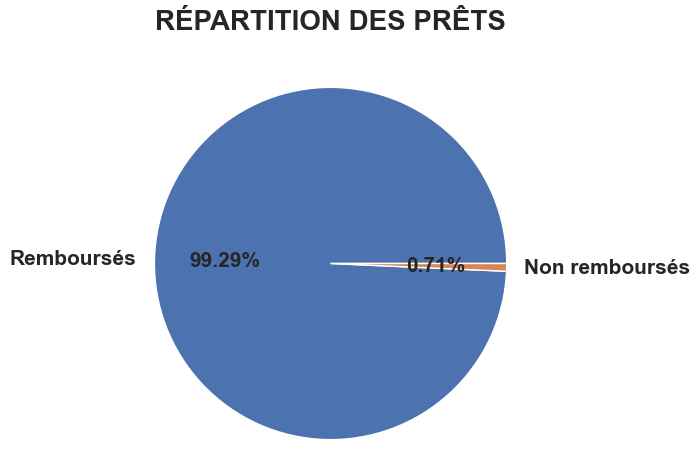

In [22]:
from preprocess_fonctions import plot_repartition
pf.plot_repartition(Bases_recents["defaut_36mois"].map(lambda x: "Remboursés" if x==0 \
                                                     else "Non remboursés"), 
                   "RÉPARTITION DES PRÊTS",
                   5, 5)

Dans notre jeu de données, une petite majorité de prêts a été remboursée. 
Il s'agit donc d'un problème avec un déséquilibre de classes. 
Lors de l'étape de modélisation, il faudra donc réfléchir à la méthodologie à employer pour obtenir un modèle performant.

#### 1.2 Distributions des données continues

In [3]:
df_dico = pd.read_excel('Data\Dictionnaire de données modif.xlsx')
df_dico.rename(columns={'Variables brutes ':'variable'}, inplace=True)

In [4]:
dicho = []
cat = []
continu = []
regrouper = []
ordinale = []
reste = []
for i in range(df_dico.shape[0]):
    if df_dico['Colonne1'][i] == 'dicho':
        #print(df_dico['variable'][i])
        dicho.append(df_dico['variable'][i])
    elif df_dico['Colonne1'][i] == 'cat':
        cat.append(df_dico['variable'][i])
    elif df_dico['Colonne1'][i] == 'continu':
        continu.append(df_dico['variable'][i])
    elif df_dico['Colonne1'][i] == 'regrouper':
        regrouper.append(df_dico['variable'][i])
    elif df_dico['Colonne1'][i] == 'ordinale':
        ordinale.append(df_dico['variable'][i])
    else:
        reste.append(df_dico['variable'][i])

In [5]:
# Convertir les variables dans le bon format 
for var in dicho:
    Bases_recents[var] = Bases_recents[var].astype("object")
    
for var in cat:
    Bases_recents[var] = Bases_recents[var].astype("object")
        
for var in ordinale :
    Bases_recents[var] = Bases_recents[var].astype("object")
    
for var in continu :
     Bases_recents[var] = Bases_recents[var].astype(float)

for var in regrouper :
    Bases_recents[var] = Bases_recents[var].astype("object")

In [6]:
#remplacer NaN par Non-Renseigné (NR)
Bases_recents.loc[74836, 'DEPARTEMENT_CRI'] = 'NR'

In [7]:
stringg = []
for i in range(Bases_recents.shape[0]):

    if type(Bases_recents['DEPARTEMENT_CRI'][i]) == str and Bases_recents['DEPARTEMENT_CRI'][i] != 'NR' :
        stringg.append(Bases_recents['DEPARTEMENT_CRI'][i])
        Bases_recents['DEPARTEMENT_CRI'][i] = int(float(Bases_recents['DEPARTEMENT_CRI'][i]))


1.2.3 Corrélations avec le risque de défaut TARGET et la Matrice de correlation entres les variables quantitatives (Coefficient de correlation de Spearman)

DISTRIBUTION DES VARIABLES CONTINUES SIGNIFICATIVES PAR RAPPPORT A LA VARIABLE CIBLE SELON LE t-Test

In [8]:
continu_significatif = []
for col in Bases_recents.columns:
    if col in continu:
        if stats.ttest_ind(Bases_recents[col].dropna()[Bases_recents['defaut_36mois'] == 0],
                Bases_recents[col].dropna()[Bases_recents['defaut_36mois'] == 1])[1] < 0.05:
            continu_significatif.append(col)

print(len(continu))
print(len(continu_significatif)) 
df_continu = Bases_recents[continu_significatif]

74
30


30 variables continues sur 74 sont significatives par rapport à la variable cyble (defaut_36mois)

#### 1.2.1 Distribution des Features quantitatives

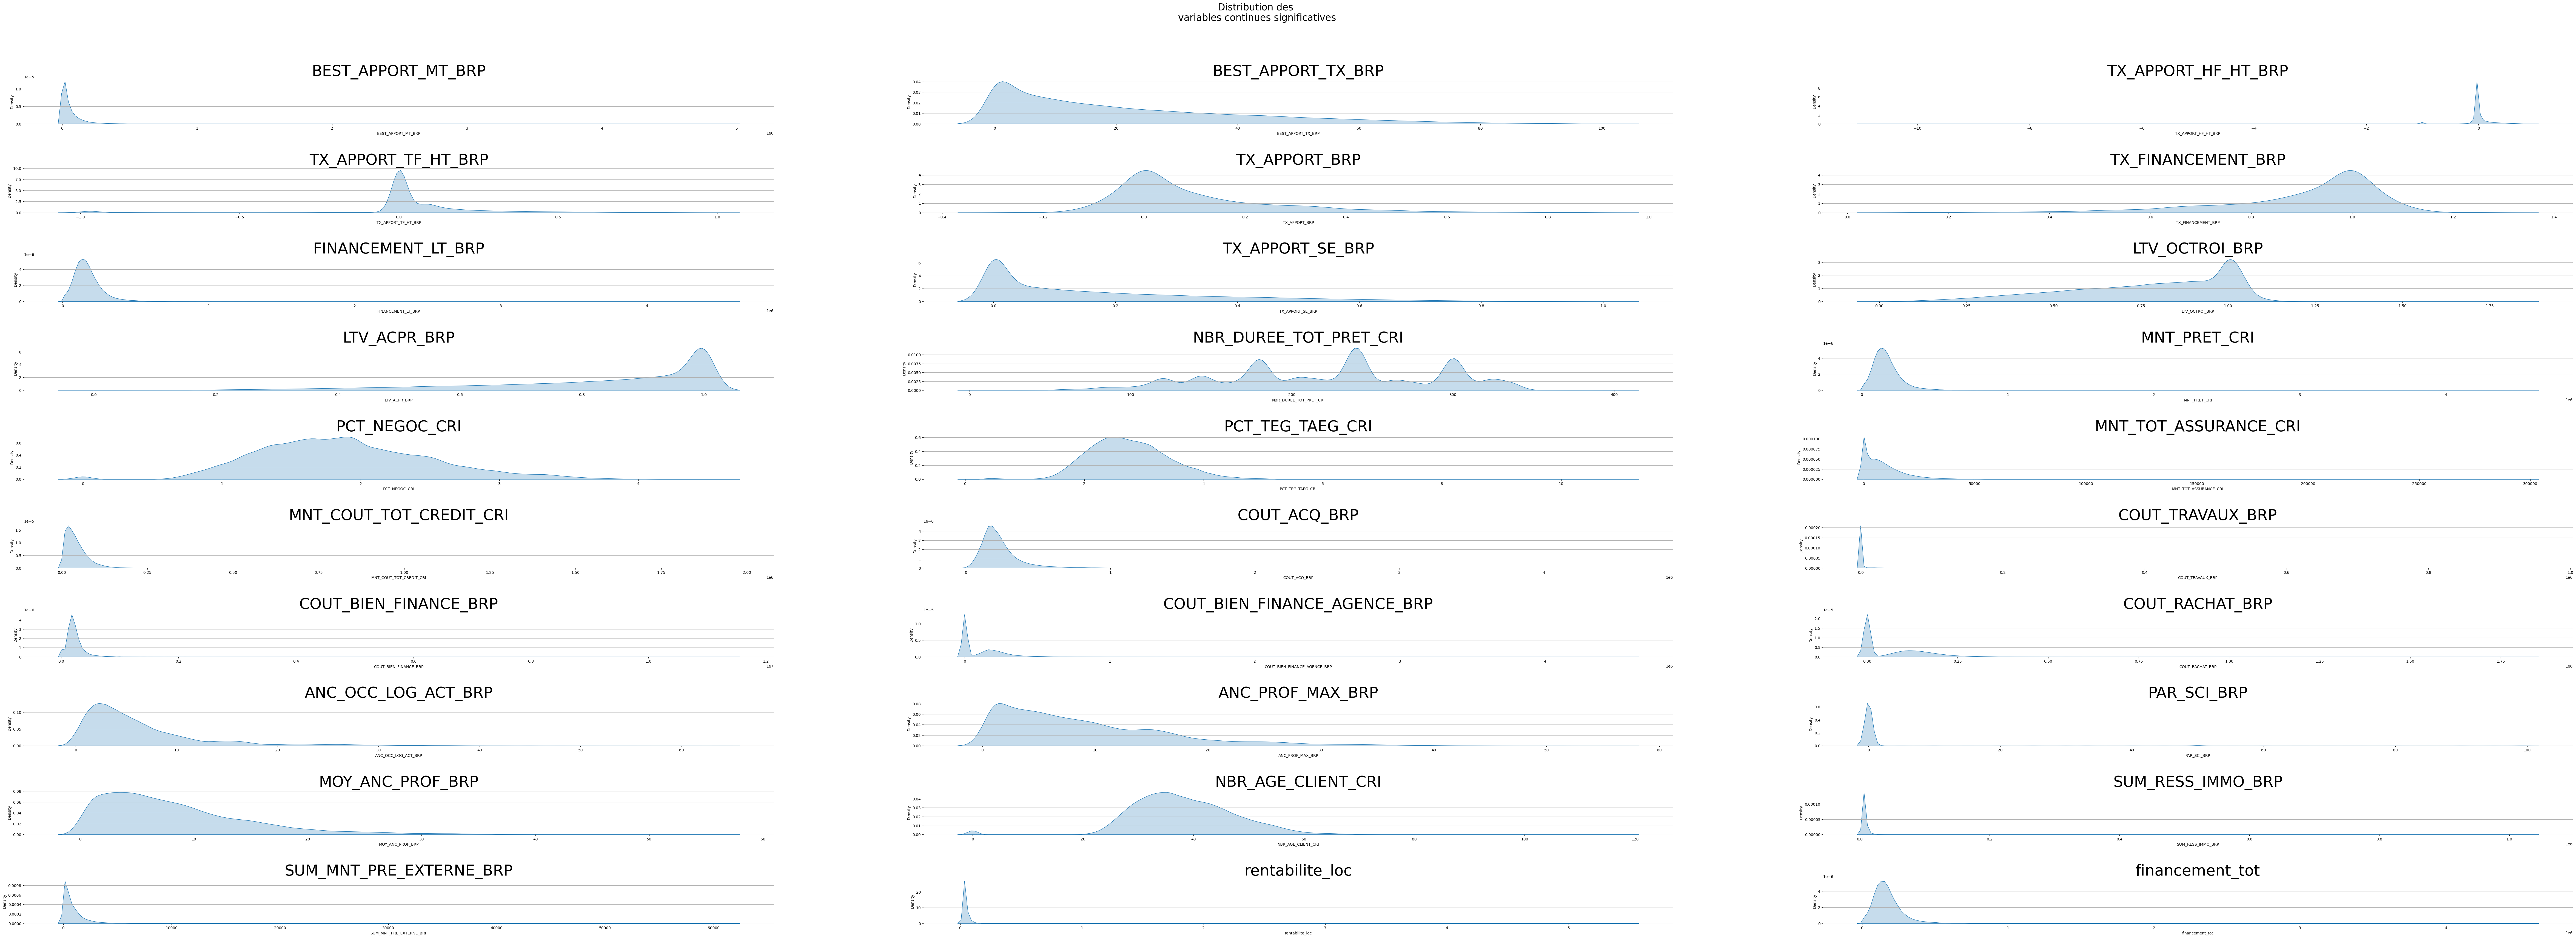

In [9]:

ncols = 3
nrows = len(continu_significatif) // ncols + (len(continu_significatif) % ncols > 0)
 
plt.figure(figsize=(120, 40))
plt.subplots_adjust(hspace=1)
plt.suptitle("Distribution des \nvariables continues significatives", fontsize=25, y=0.95)
 
for n, variable in enumerate(continu_significatif):
    # add a new subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)
 
    sns.kdeplot(ax=ax, data=Bases_recents[variable], legend=None, shade=True)
    ax.grid(b=True, which='major', axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.set_title(variable, loc= 'center', fontsize=40)

#### 1.2.2 Valeurs aberrantes

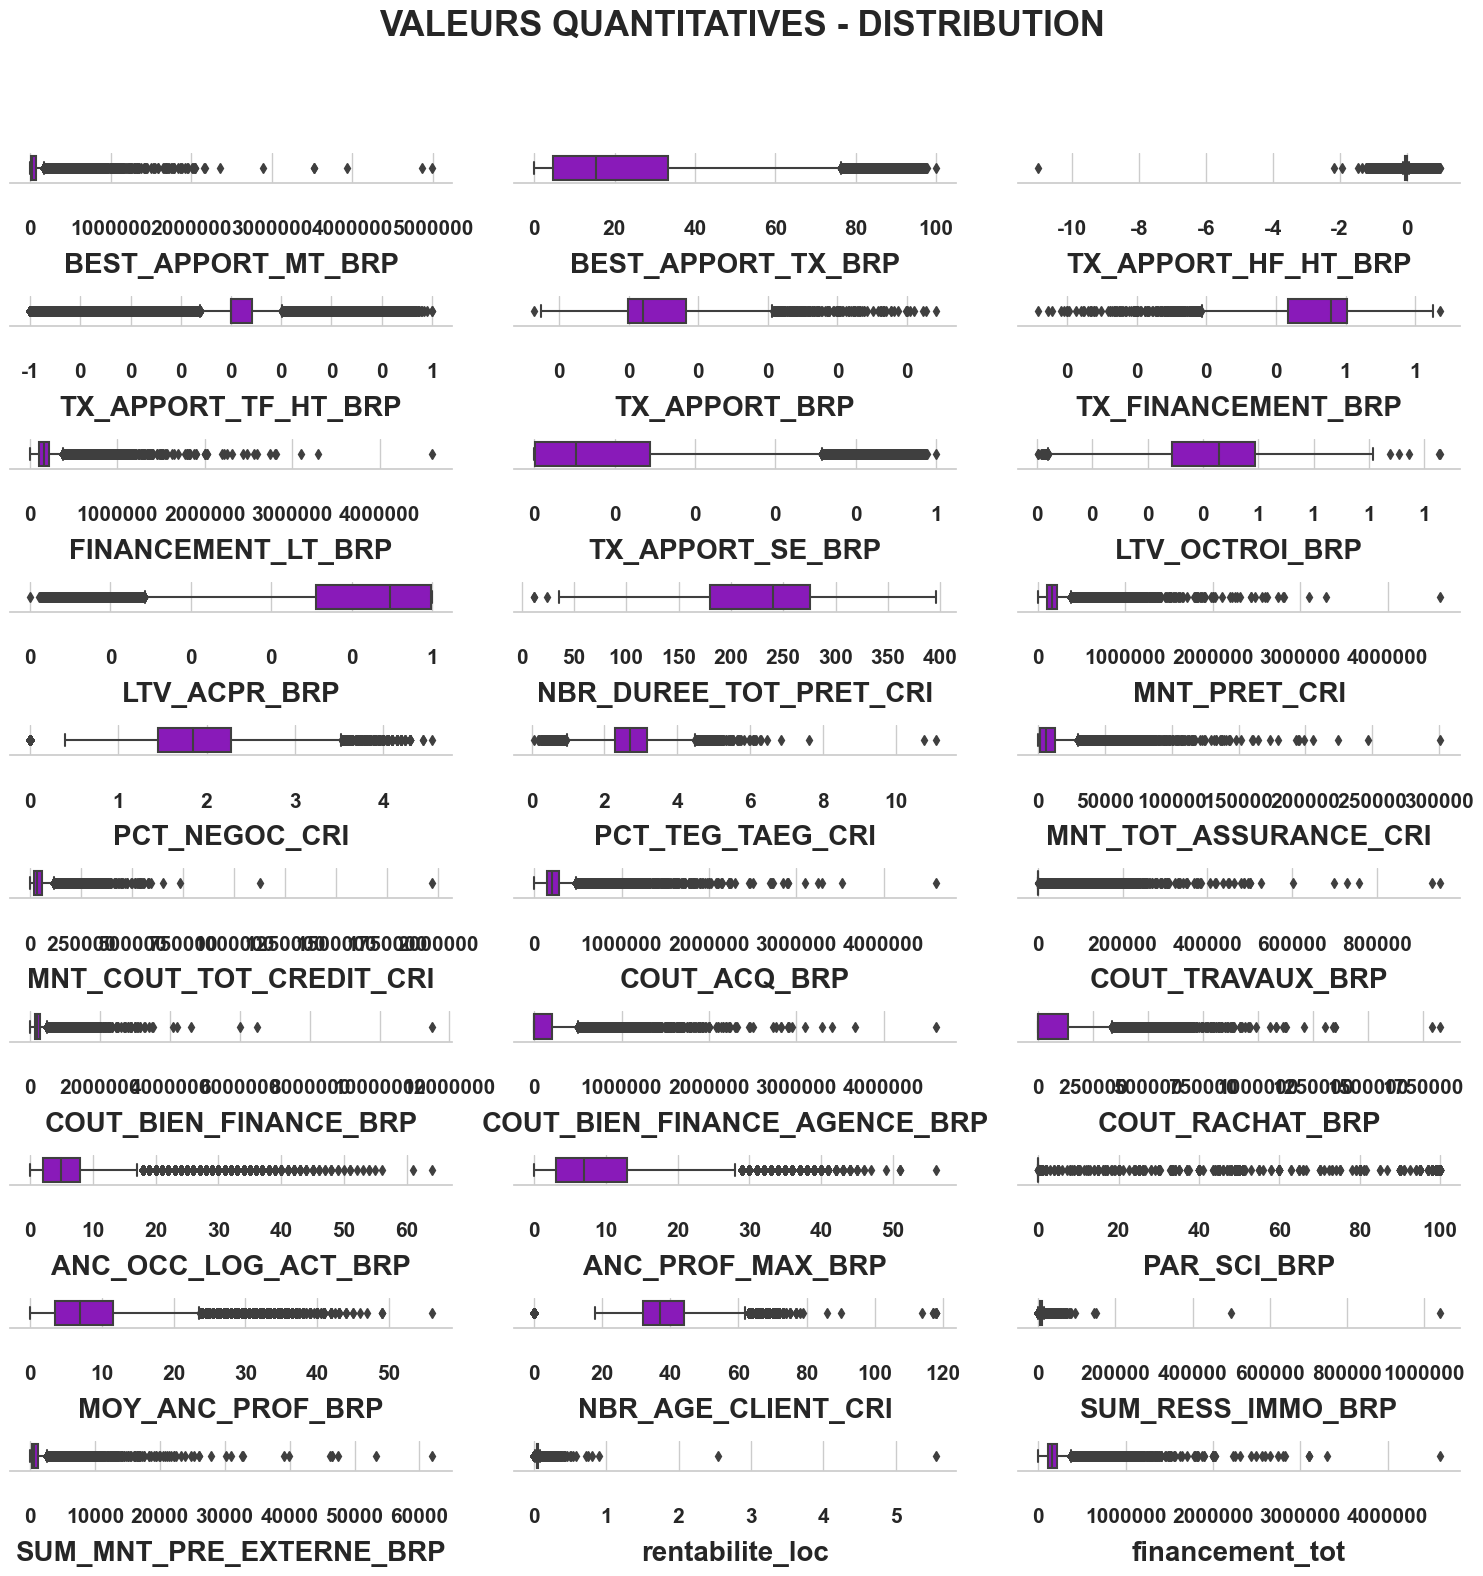

In [18]:
from preprocess_fonctions import plotBoxPlots
pf.plotBoxPlots(continu_significatif, 15, 15, 10, 3)

Parmi les variables continues significatives par rapport à la variable cible, nous remarquons des valeurs aberrantes. Le traitement sera mis en place dans la suite.

#### Le code suivant permet d'afficher les valeurs d'expression pour chaque variable continue, rangées par les moyennes.

<AxesSubplot: ylabel='Expression'>

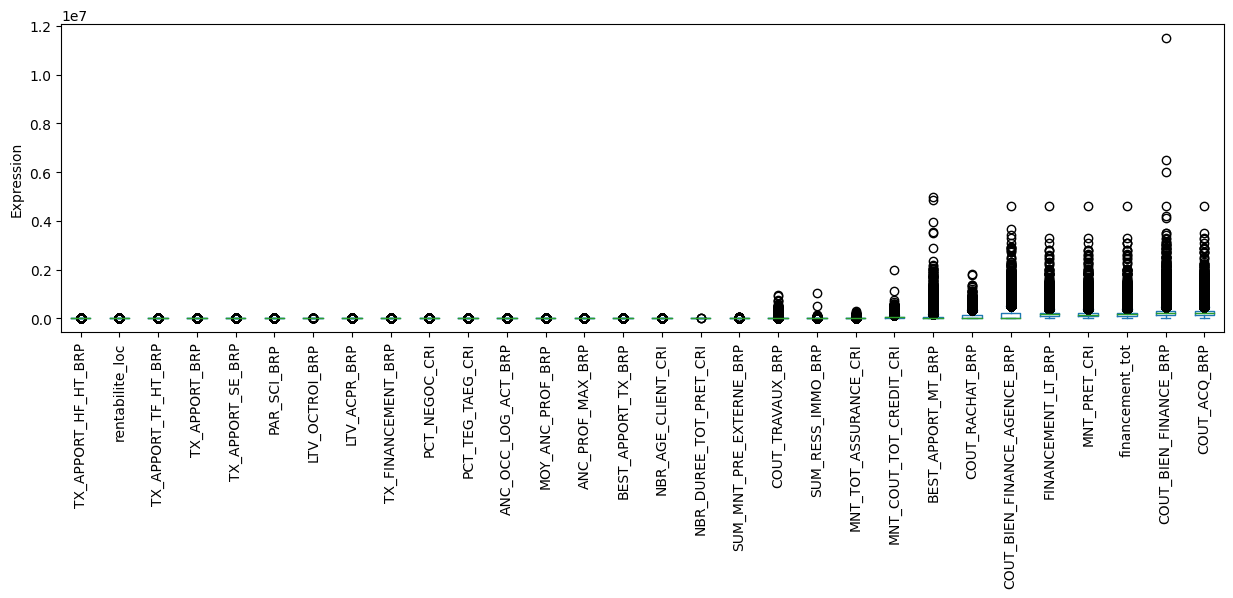

: 

In [11]:
sort_by_mean = df_continu.mean().sort_values(ascending=True)
df_continu[sort_by_mean.index].plot(kind='box', figsize=(15, 4), rot=90, ylabel='Expression')

Pour certaines variables continues les niveaux d’expression varient beaucoup, pour d’autres non. Les plages de valeurs sont différentes d’une variable à l’autre. Cette situation peut impacter le modele que nous allons mettre en place. Pour la suite, les veleurs aberrantes sont classées dans une classe particuliere pour ne pas impacter le resultat final.

#### La matrice de correlation de Spearman entre les variables continues significatives à la variables cible

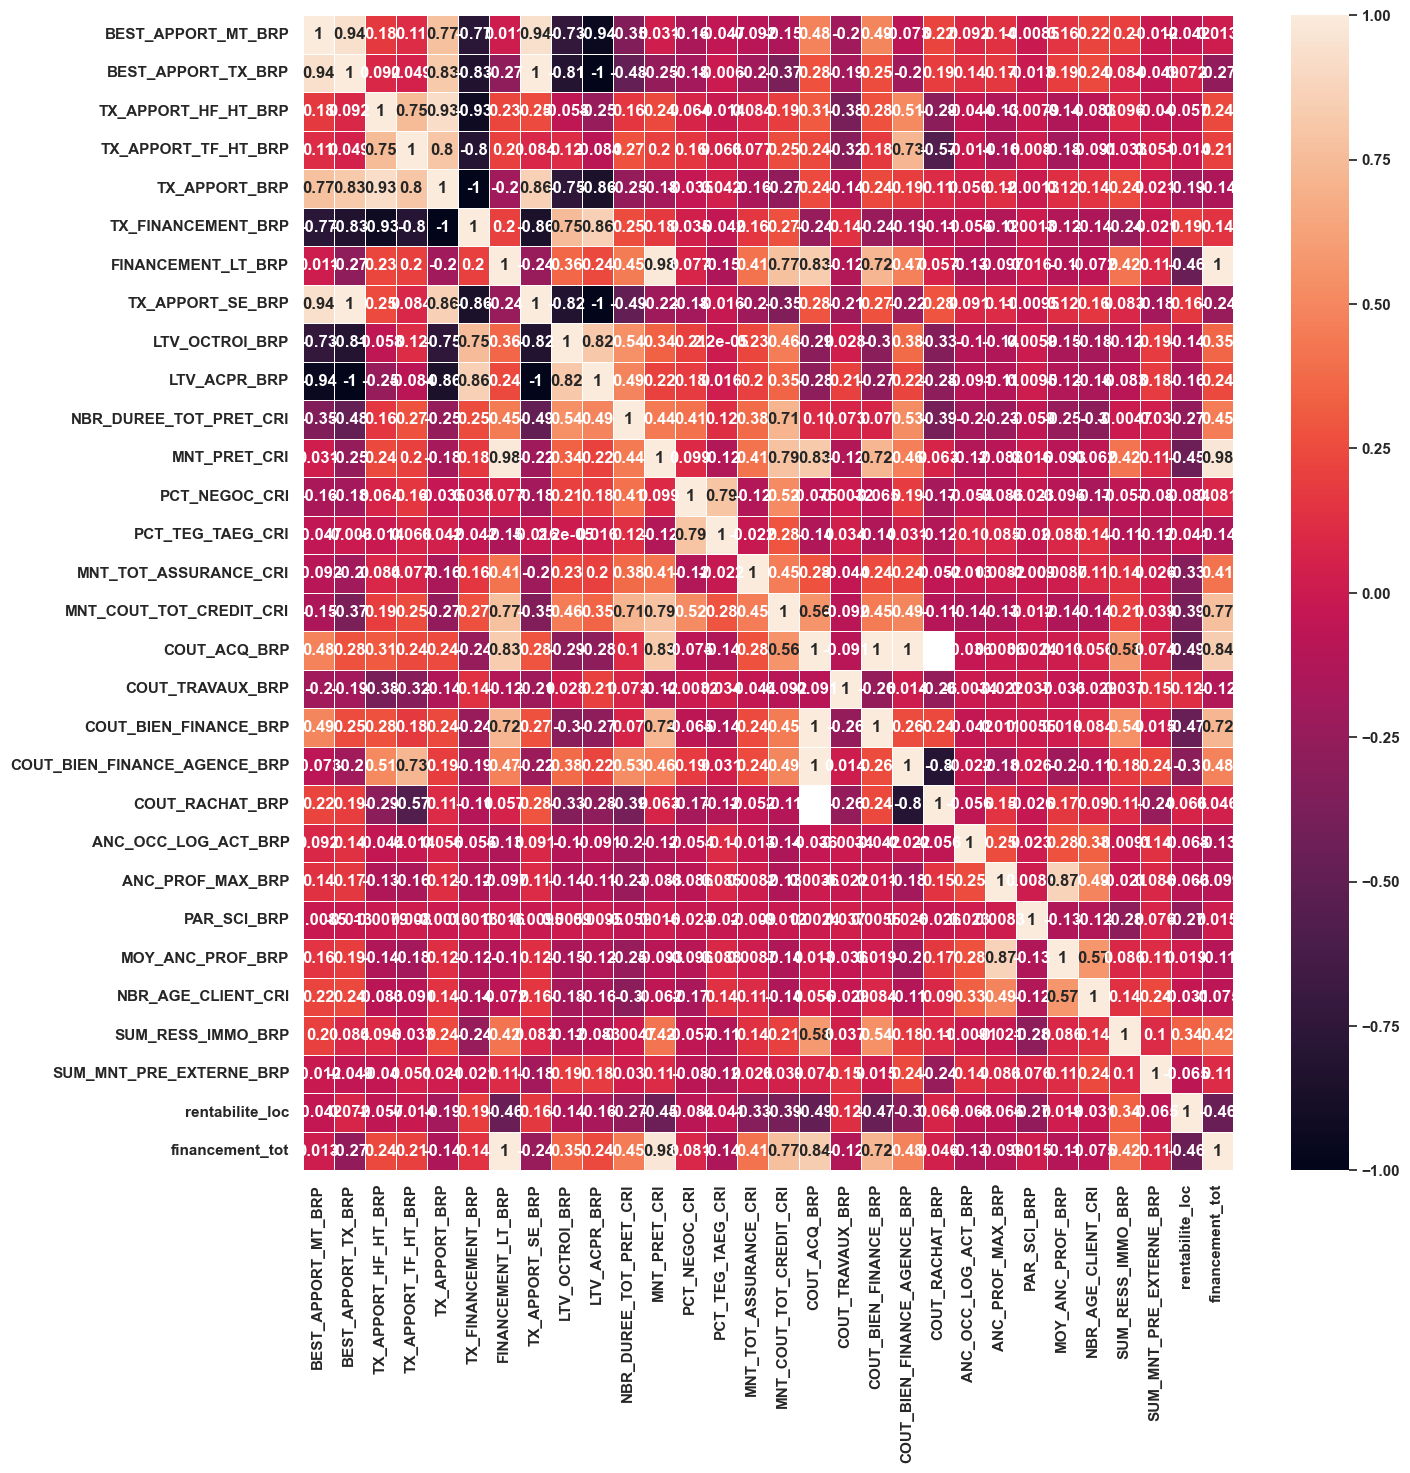

In [31]:
correlation_s =df_continu.corr('spearman')
fig, ax = plt.subplots(figsize=(15,15))
heatmap = sns. heatmap(correlation_s, annot = True, linewidths=.5, ax=ax) 

Il y a des variables correlées entre eles : ex: Tx_Financement_BRP, LTV_OCTROI_BRP, LTV_ACPR_BRP (que nous regrouperons dans la suit)

#### 1.3 Analyse des Features qualitatatives

### Significativité selon le test de Chi-2 pour les variables dichotomiques

In [32]:
dicho_significative = []
for col in dicho:
    crosstab, test_results, expected = rp.crosstab(Bases_recents["defaut_36mois"], Bases_recents[col],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
    if test_results['results'][1] < 0.05:
        dicho_significative.append(col)

In [33]:
print(len(dicho_significative), ' variables dichotomiques parmi ', len(dicho), 'sont significatives au sens de Chi 2')

8  variables dichotomiques parmi  14 sont significatives au sens de Chi 2


Parmi les 14 variables binaires, uniquement 8 sont significatives au sens de Chi-2 avec la variable cible

### Analyse des variables catégorielles et ordinales

- La variable ordinale est gardé, car la p_value du test de wilcoxon est inferieure à 5%

In [34]:
for col in ordinale:
    print(stats.wilcoxon(Bases_recents[col],Bases_recents['defaut_36mois']))

WilcoxonResult(statistic=0.0, pvalue=0.0)


In [35]:
#for col in cat:
#    print(col)
#    print(Bases_recents[col].unique())
#    print('----------------')

for col in cat:
     Bases_recents[col] = Bases_recents[col].fillna("NR")
#    print(Bases_recents[col].value_counts())
#    print('--------------')

In [36]:
df_defaut = Bases_recents.loc[(Bases_recents["defaut_36mois"] == 1)]
df_defaut = df_defaut[df_defaut.columns[df_defaut.columns.isin(cat)]]
#df_defaut

#### 2. Data visualization et nettoyage préliminaire des données
### 2.1 Suppression des NaN

On supprime les variables avec plus de 80% de valeurs manquantes, car on a pas assez de données renseignées d'un point de vue analytique. Cela concerne que cette etape de data visualisation . Au contraire, pendant l’étape de modélisation nous avons procédé à une imputation des variables manquantes avec un «NR » et les classées d’après la discrétisation d’OptBinning dans une modalité différente des autres .

In [37]:
missing_rate = pd.DataFrame({'count': Bases_recents.isna().sum(),'rate': (Bases_recents.isna().sum()*100/Bases_recents.shape[0])})
to_drop= missing_rate[missing_rate['rate']>80]
Bases_recents = Bases_recents.drop(to_drop.index, axis = 1)

In [38]:
from preprocess_fonctions import valeur_nan
print("Nombres de variables comprenant des valeurs manquantes : " + 
      str(len(pf.valeur_nan(Bases_recents)[valeur_nan(Bases_recents)['Total']!=0])))

Nombres de variables comprenant des valeurs manquantes : 26


Les valeurs manquantes pour les variables ci-dessous sont renseignées par un NR nous corrigeons cela

In [39]:
Bases_recents['COD_POSTAL_BIEN_CRI'] = Bases_recents['COD_POSTAL_BIEN_CRI'].str.replace('NR','nan',regex=True)
Bases_recents['DEPARTEMENT_CRI'] = Bases_recents['DEPARTEMENT_CRI'].str.replace('NR','nan',regex=True)

Bases_recents['TX_APPORT_HF_AT_BRP'] = Bases_recents['TX_APPORT_HF_AT_BRP'].mask(Bases_recents['TX_APPORT_HF_AT_BRP'] < 0, np.nan)
Bases_recents['TX_APPORT_HF_AT_BRP'] = Bases_recents['TX_APPORT_HF_AT_BRP'].replace('NR','nan',regex=True)

Bases_recents['TX_APPORT_HF_HT_BRP'] = Bases_recents['TX_APPORT_HF_HT_BRP'].mask(Bases_recents['TX_APPORT_HF_HT_BRP'] < 0, np.nan)
Bases_recents['TX_APPORT_HF_HT_BRP'] = Bases_recents['TX_APPORT_HF_HT_BRP'].replace('NR','nan',regex=True)

Bases_recents['TX_APPORT_TF_AT_BRP'] = Bases_recents['TX_APPORT_TF_AT_BRP'].mask(Bases_recents['TX_APPORT_TF_AT_BRP'] < 0, np.nan)
Bases_recents['TX_APPORT_TF_AT_BRP'] = Bases_recents['TX_APPORT_TF_AT_BRP'].replace('NR','nan',regex=True)

Bases_recents['TX_APPORT_TF_HT_BRP'] = Bases_recents['TX_APPORT_TF_HT_BRP'].mask(Bases_recents['TX_APPORT_TF_HT_BRP'] < 0, np.nan)
Bases_recents['TX_APPORT_TF_HT_BRP'] = Bases_recents['TX_APPORT_TF_HT_BRP'].replace('NR','nan',regex=True)

- Les taux negatifs sont remplacés par des NR car en effet il ne peut pas y avoir de taux négatif.
- Les valeurs aberrante sont corrigé par la méthode de la discrétisation (pour le 1er taux)

In [40]:
Bases_recents['nb_pret'] = Bases_recents['nb_pret'].astype(int)

In [41]:
from preprocess_fonctions import nettoyage_age
Bases_recents['NBR_AGE_CLIENT_CRI'] = Bases_recents['NBR_AGE_CLIENT_CRI'].apply(pf.nettoyage_age)
Bases_recents['NBR_AGE_CLIENT_CRI'] = Bases_recents['NBR_AGE_CLIENT_CRI'].astype(float)

Bases_recents['AGE_INT_MAX_BRP'] = Bases_recents['AGE_INT_MAX_BRP'].apply(pf.nettoyage_age)
Bases_recents['AGE_INT_MAX_BRP'] = Bases_recents['AGE_INT_MAX_BRP'].astype(float)

### 2.2 Analyse de la variable Age
Nous pensons que l'âge est un premier gros indicateur de pouvoir accordé un prêt ou non à un client.

In [42]:
Bases_recents['NBR_AGE_CLIENT_CRI'].describe()

count    113263.000000
mean         38.676823
std           8.552302
min          18.000000
25%          32.000000
50%          38.000000
75%          44.000000
max         118.000000
Name: NBR_AGE_CLIENT_CRI, dtype: float64

Nous remarquons la présence d'outliers que l'on traitera plus tard.

<AxesSubplot: xlabel='NBR_AGE_CLIENT_CRI', ylabel='Count'>

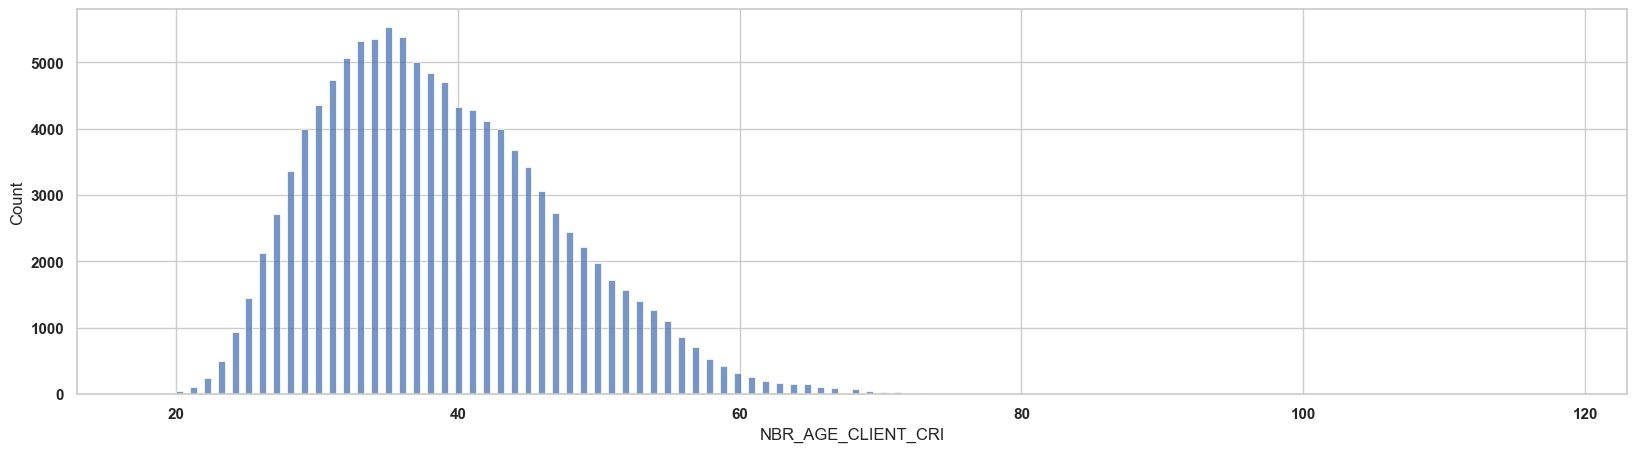

In [43]:
plt.figure(figsize=(20, 5))
sns.histplot(Bases_recents['NBR_AGE_CLIENT_CRI'])

* Visualization du taux de defaut en fonction d'age.

<AxesSubplot: xlabel='NBR_AGE_CLIENT_CRI', ylabel='Count'>

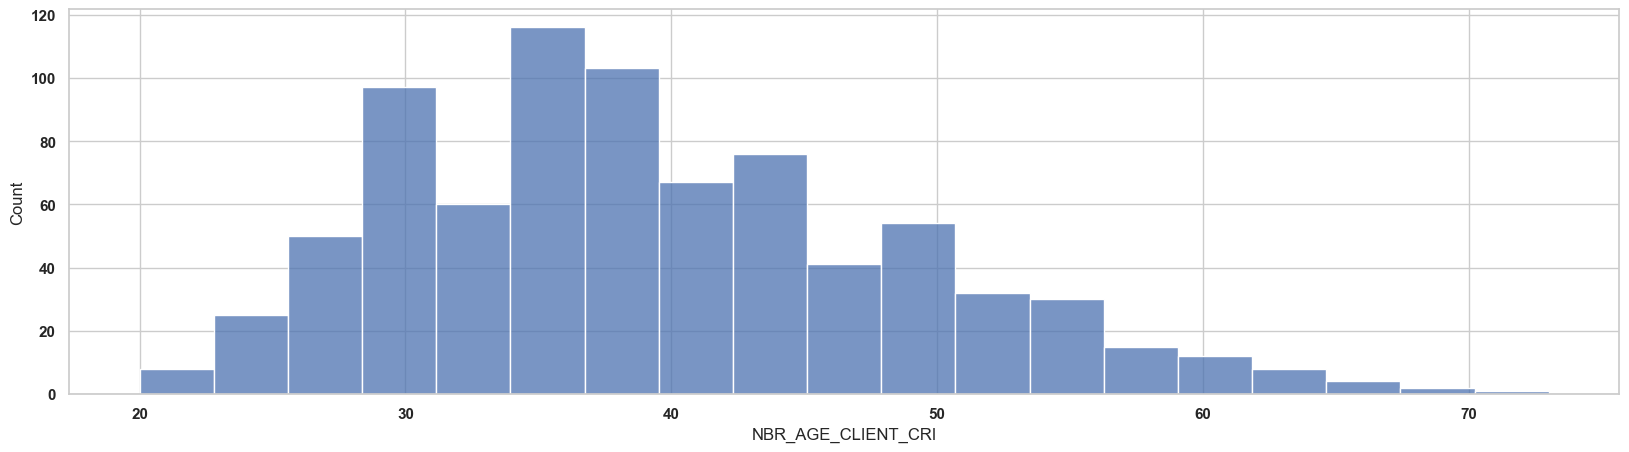

In [44]:
Bases_recents_defaut = Bases_recents[Bases_recents['defaut_36mois'] == 1]
plt.figure(figsize=(20, 5))
sns.histplot(Bases_recents_defaut['NBR_AGE_CLIENT_CRI'])

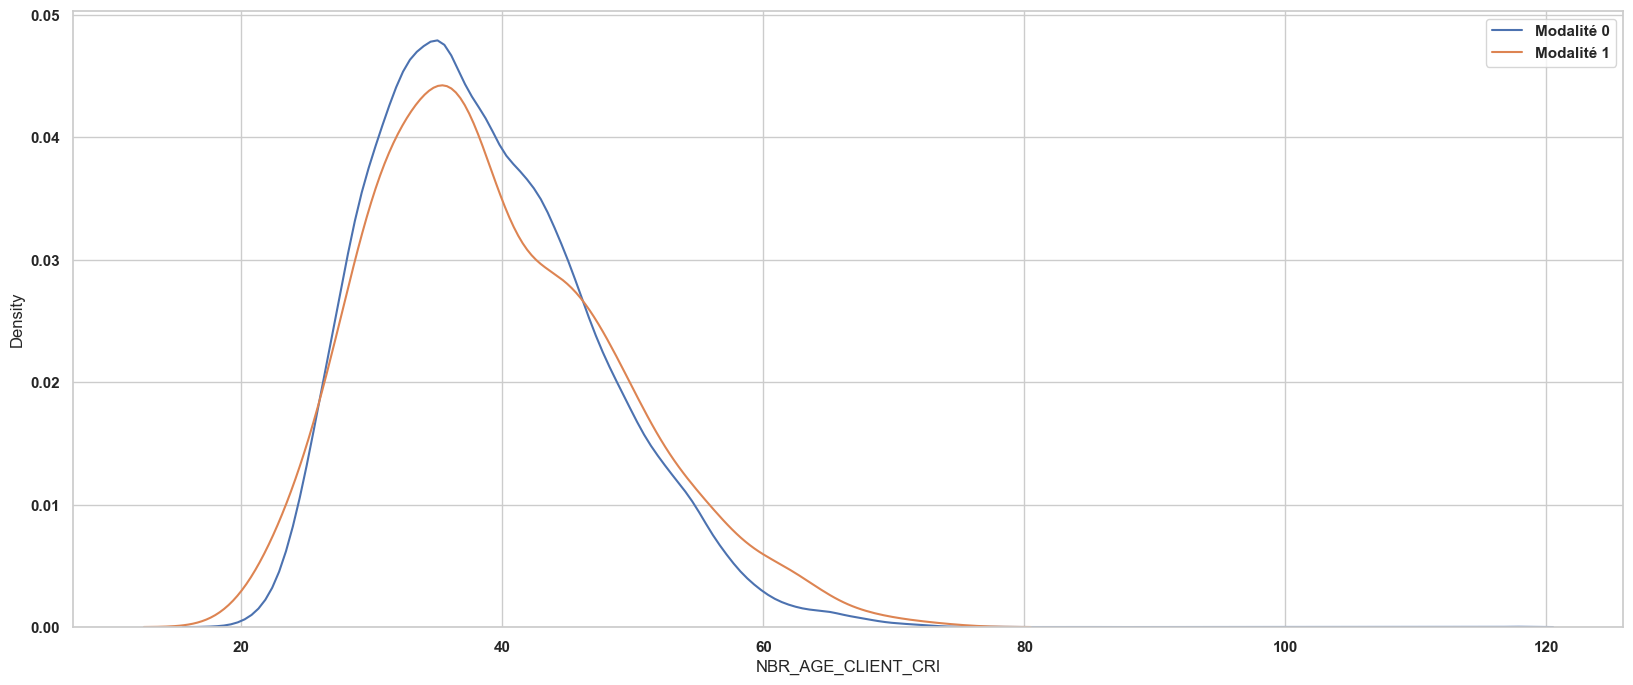

In [45]:
plt.figure(figsize = (20, 8))
sns.kdeplot(Bases_recents[Bases_recents['defaut_36mois'] == 0]['NBR_AGE_CLIENT_CRI'], label = 'Modalité 0')
sns.kdeplot(Bases_recents[Bases_recents['defaut_36mois'] == 1]['NBR_AGE_CLIENT_CRI'], label = 'Modalité 1')
plt.legend()
plt.show()

Vers les 20 ans et vers les 60 ans il n'y a plus de chances de faire défaut

In [46]:
from preprocess_fonctions import impact_defaut
from preprocess_fonctions import visualisation_modalite

### 2.3 Anzlyse de la variable contrat de travail

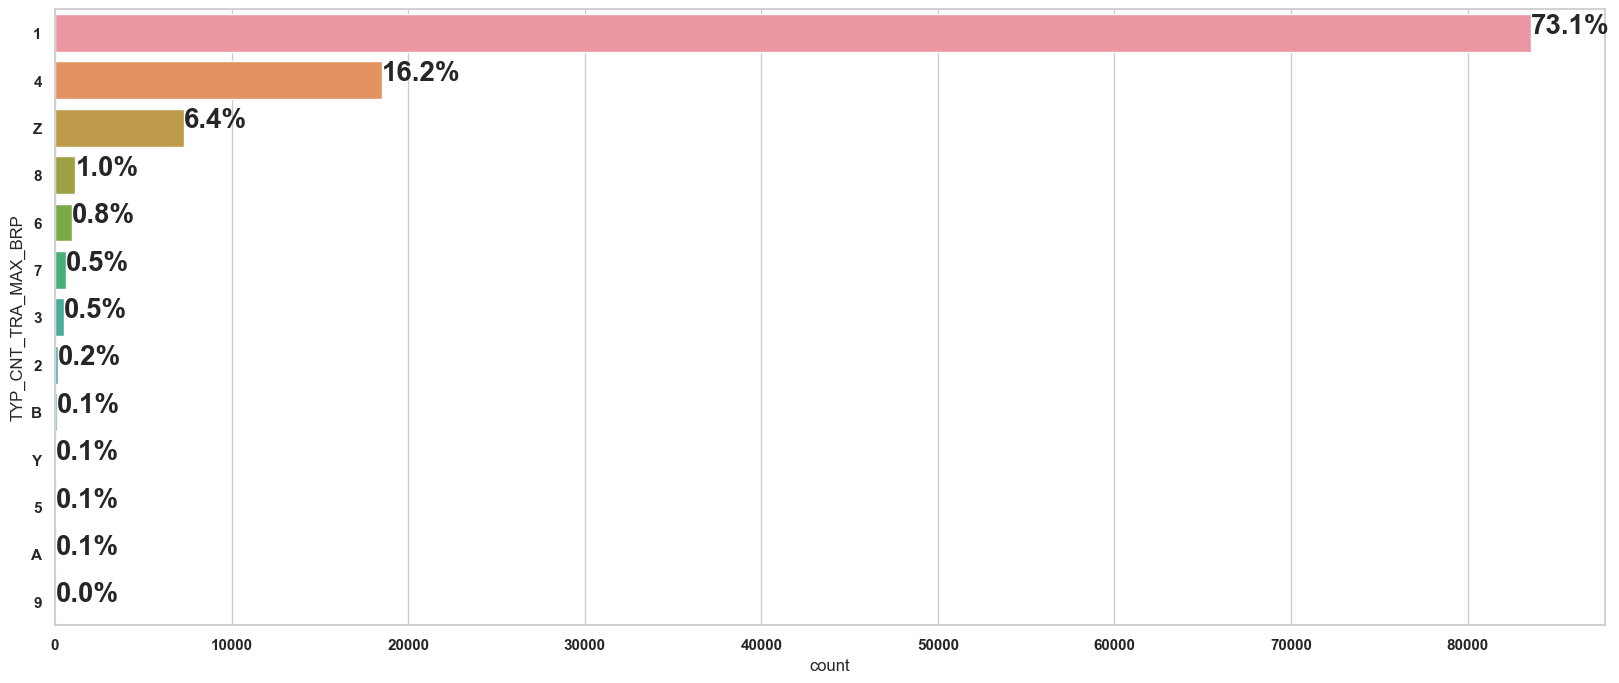

In [38]:
pf.visualisation_modalite(Bases_recents, 'TYP_CNT_TRA_MAX_BRP')

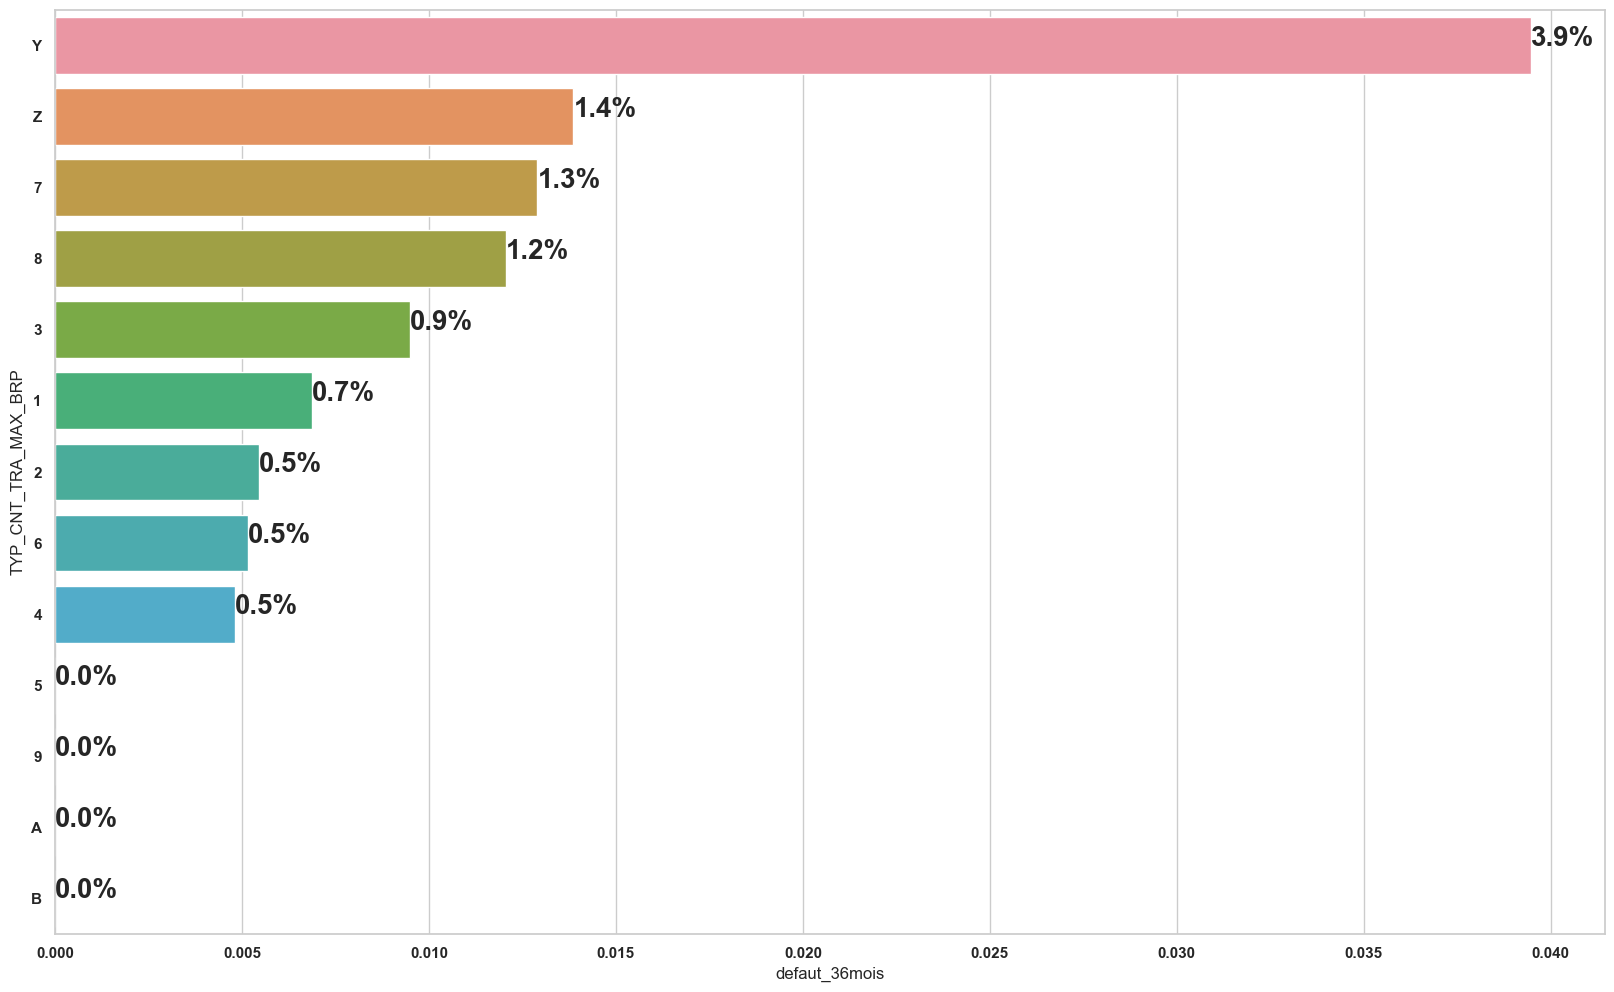

In [39]:
pf.impact_defaut(Bases_recents, 'TYP_CNT_TRA_MAX_BRP')

Cela nous confirme que lorsque nous nous trouvons en situation pas stable nous avons plus de chances de tomber en défaut, par exemple on voit qu'il y a peu de personnes en CDI qui ne remboursent pas alors que se sont plutot les étudiants ou les autres (artisans...) qui ne remboursent pas leur prêt.

### 2.4 Analyse de la variable Genre

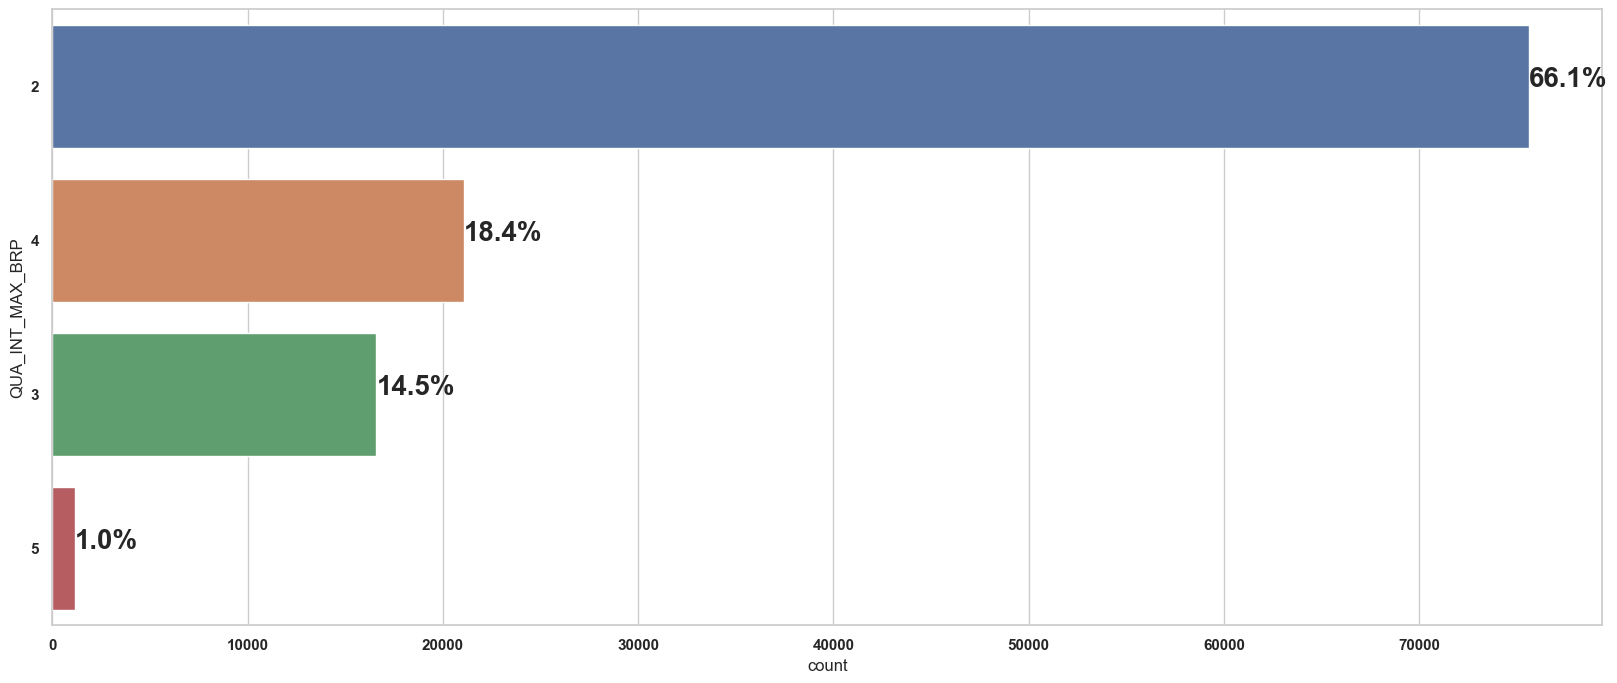

In [40]:
pf.visualisation_modalite(Bases_recents, 'QUA_INT_MAX_BRP')

### 2.5 Analyse de la variable Métier

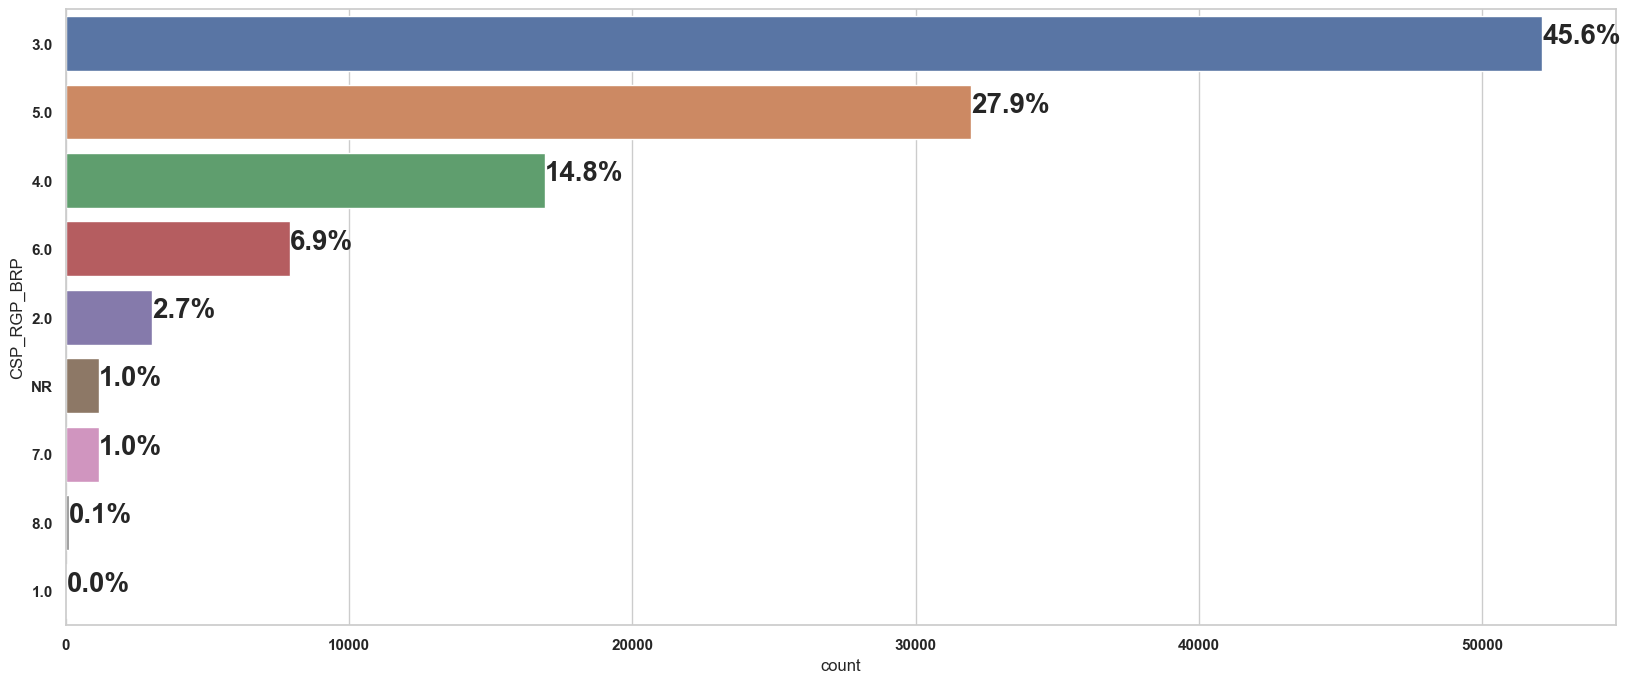

In [47]:
pf.visualisation_modalite(Bases_recents, 'CSP_RGP_BRP')

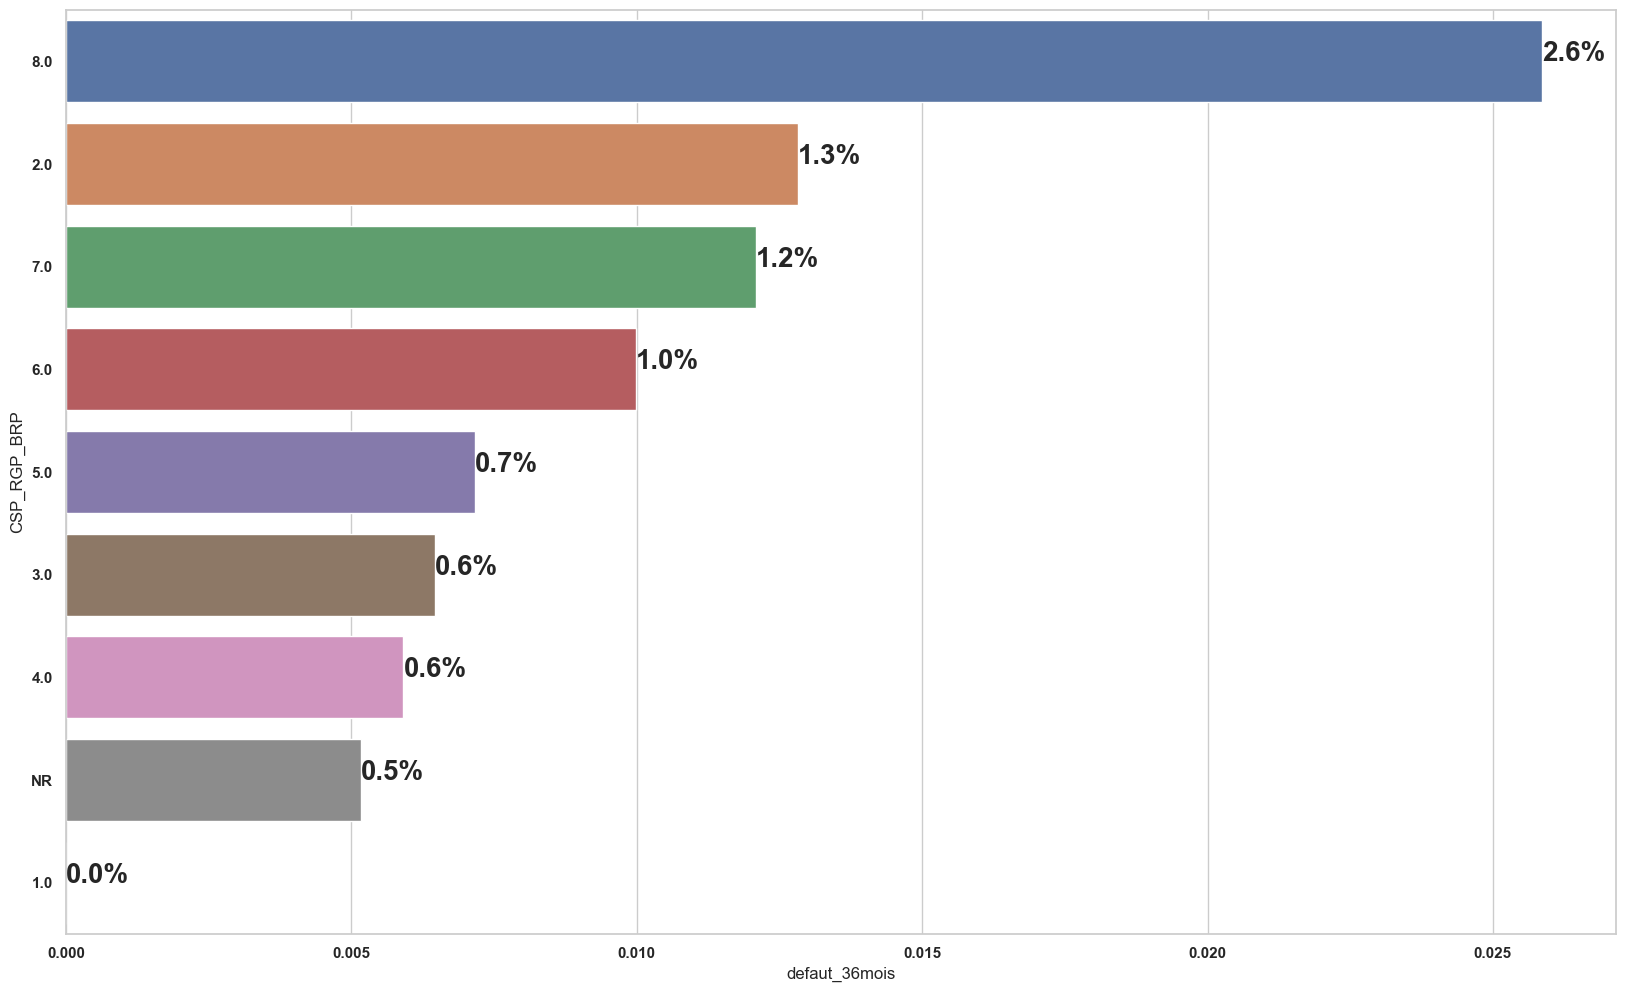

In [48]:
pf.impact_defaut(Bases_recents, 'CSP_RGP_BRP')

___
### 2. Conclusion
___

L'analyse a pu mettre en lumière plusieurs informations importantes pour la modélisation à venir :
- 13% des features du jeu de données ont 50% de valeurs manquantes.
- Pour certains variables continues les niveaux d’expression varient beaucoup (ex: cout de financement)
- La situation financiere et sociale du client impacte la probabilité de tomber en défaut.